In [40]:
%matplotlib inline

In [41]:
import urllib2 as url
import re
import numpy as np

mesh_url="http://braincatalogue.org/data/Ferret/mesh.ply"
response=url.urlopen(mesh_url)
text=response.read()
text=text.split("\n")

In [42]:
parser=re.compile("\d+")
for line in text:
    if "element vertex" in line:
        nv=int(parser.findall(line)[0])
    if "element face" in line:
        nt=int(parser.findall(line)[0])
    if "end_header" in line:
        off=text.index(line)+1
        break
print "Reading",nv,"vertices and",nt,"triangles."

p=np.array([])
for i in range(off,off+nv):
    p=np.concatenate([p,np.fromstring(text[i],dtype=float,sep=" ")])
p=p.reshape(nv,3)

t=np.array([])
for i in range(off+nv,off+nv+nt):
    tr=np.fromstring(text[i],dtype=int,sep=" ");
    t=np.concatenate([t,[tr[1],tr[2],tr[3]]])
t=t.reshape(nt,3)

#p = vertices
#t = triangles

x = p[:,0]
y = p[:,1]
z = p[:,2]


Reading 9991 vertices and 20000 triangles.


In [29]:
vertices = p

def normalize_v3(arr):
    ''' Normalize a numpy array of 3 component vectors shape=(n,3) '''
    lens = numpy.sqrt( arr[:,0]**2 + arr[:,1]**2 + arr[:,2]**2 )
    arr[:,0] /= lens
    arr[:,1] /= lens
    arr[:,2] /= lens                
    return arr

In [39]:
t[1,::]

array([ 0.,  2.,  3.])

In [26]:
#Create a zeroed array with the same type and shape as our vertices i.e., per vertex normal
norm = numpy.zeros( vertices.shape, dtype=vertices.dtype )
#Create an indexed view into the vertex array using the array of three indices for triangles
tris = t
#Calculate the normal for all the triangles, by taking the cross product of the vectors v1-v0, and v2-v0 in each triangle             
n = numpy.cross( tris[::,1 ] - tris[::,0]  , tris[::,2 ] - tris[::,0] )
# n is now an array of normals per triangle. The length of each normal is dependent the vertices, 
# we need to normalize these, so that our next step weights each normal equally.
normalize_v3(n)
# now we have a normalized array of normals, one per triangle, i.e., per triangle normals.
# But instead of one per triangle (i.e., flat shading), we add to each vertex in that triangle, 
# the triangles' normal. Multiple triangles would then contribute to every vertex, so we need to normalize again afterwards.
# The cool part, we can actually add the normals through an indexed view of our (zeroed) per vertex normal array
norm[ faces[:,0] ] += n
norm[ faces[:,1] ] += n
norm[ faces[:,2] ] += n
normalize_v3(norm)

ValueError: incompatible dimensions for cross product
(dimension must be 2 or 3)

In [30]:
print tris

[[  2.00000000e+00   1.40000000e+01   1.00000000e+00]
 [  0.00000000e+00   2.00000000e+00   3.00000000e+00]
 [  6.00000000e+00   2.00000000e+00   1.00000000e+00]
 ..., 
 [  9.98500000e+03   9.98600000e+03   9.98700000e+03]
 [  9.98800000e+03   9.98700000e+03   9.99000000e+03]
 [  9.98900000e+03   9.99000000e+03   9.98700000e+03]]


In [16]:
import numpy as np

def calculate_normals(p, t):
    '''
    Calculate the normals of each vertex of a mesh
    as the weighted average of the normals of all faces
    it is part of
    '''
    
    face_normals = np.cross( t[::,1 ] - t[::,0]  , t[::,2 ] - t[::,0] )
    face_normals /= 2 # weighting by surface area of the triangle, which is half the length of the normal
    
    vertex_normals = np.zeros(p.shape, dtype=p.dtype)
    vertex_count = np.zeros(p.shape[0])
    
    for face in range(t.shape[0]):
        vertex_normals[t[face]] += face_normals[face]
        vertex_count[t[face]] += 1
   
    # divide by actual number of faces
    vertex_normals /= vertex_count[:, np.newaxis]
    
    return vertex_normals


In [15]:
print p

[[-6.864583 -1.474754 -8.452395]
 [-8.184962 -1.051406 -8.451191]
 [-7.527279 -1.207996 -8.490135]
 ..., 
 [ 0.98116  -5.726964  8.461373]
 [ 1.852013 -5.142472  8.372536]
 [ 1.073178 -5.072615  8.407865]]


In [43]:
from mayavi import mlab
from scipy.special import sph_harm
mlab.triangular_mesh(x, y, z, t)
mlab.show()

In [44]:
import sys
import os
import platform

# Mindboogle

mindbog=os.path.join('mindboggle-master')
sys.path.append(mindbog)
sys.path.append(os.path.join(mindbog,'mindboggle/shapes'))

import laplace_beltrami as LB
import numpy
import scipy
import time

In [45]:
points=numpy.array(p)
faces=numpy.array(t, dtype = numpy.int_)

A,B=LB.computeAB(points, faces)
#A and B will be used to compute laplace beltrami eigenfunstions or fourier modes

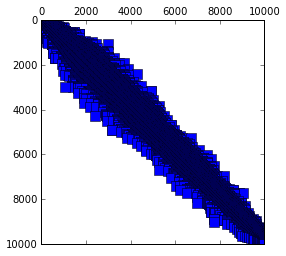

In [46]:
import matplotlib.pylab as plt
plt.spy(A)
plt.show()

In [8]:

#t=time.time()
ev,evec=LB.fem_laplacian(points, faces, 20)
#print time.time()-t

Compute linear FEM Laplace-Beltrami spectrum


In [47]:
mlab.triangular_mesh(x, y, z, t, scalars = evec[:, 2])
mlab.show()

In [48]:
from sklearn.cluster import KMeans

random_state = 42
y_pred = KMeans(n_clusters=8, random_state = random_state).fit_predict(evec[:, 2:7])

In [11]:
evec[:, 2:3].shape

(9991, 1)

In [12]:
mlab.triangular_mesh(x, y, z, t, scalars = y_pred, colormap='Set1')
mlab.show()

In [13]:
#here starts matlab

import matlab.engine
eng = matlab.engine.start_matlab()

eng.addpath('/Users/ghfc/Documents/Dropbox/hugo_is_dead/scripts/JL_Toolboxes_v1.2/');
eng.addpath('/Users/ghfc/Documents/Dropbox/hugo_is_dead/scripts/JL_Toolboxes_v1.2/Toolboxes/');
eng.addpath('/Users/ghfc/Documents/Dropbox/hugo_is_dead/scripts/matlab/extensions/fieldtrip/currentversion/public/');
#for some reasons it doesn't work if you don't add all the paths with scripts :/ 
#there must be a solutions, need to search
eng.addpath('/Users/ghfc/Documents/Dropbox/hugo_is_dead/scripts/JL_Toolboxes_v1.2/Toolboxes/GeometryMesh/', 
            '/Users/ghfc/Documents/Dropbox/hugo_is_dead/scripts/JL_Toolboxes_v1.2/Toolboxes/ReactionDiffusion/',
            '/Users/ghfc/Documents/Dropbox/hugo_is_dead/scripts/JL_Toolboxes_v1.2/Toolboxes/SpectralSphericalMapping/',
            '/Users/ghfc/Documents/Dropbox/hugo_is_dead/scripts/JL_Toolboxes_v1.2/Toolboxes/GeneralFunctionsMatrices/',
            '/Users/ghfc/Documents/Dropbox/hugo_is_dead/scripts/JL_Toolboxes_v1.2/Toolboxes/GeneralFunctionsMesh/',
            '/Users/ghfc/Documents/Dropbox/hugo_is_dead/scripts/JL_Toolboxes_v1.2/Toolboxes/GyrificationIndex/',
            '/Users/ghfc/Documents/Dropbox/hugo_is_dead/scripts/JL_Toolboxes_v1.2/Toolboxes/GyrificationIndex/',
            '/Users/ghfc/Documents/Dropbox/hugo_is_dead/scripts/JL_Toolboxes_v1.2/Toolboxes/MorphomathMesh/',
            '/Users/ghfc/Documents/Dropbox/hugo_is_dead/scripts/JL_Toolboxes_v1.2/Toolboxes/PDEMesh/',
            '/Users/ghfc/Documents/Dropbox/hugo_is_dead/scripts/JL_Toolboxes_v1.2/Toolboxes/Partitions/',
            '/Users/ghfc/Documents/Dropbox/hugo_is_dead/scripts/JL_Toolboxes_v1.2/Toolboxes/Registration/',
            '/Users/ghfc/Documents/Dropbox/hugo_is_dead/scripts/JL_Toolboxes_v1.2/Toolboxes/SphericalDemons-v1.1-svn593/',
            '/Users/ghfc/Documents/Dropbox/hugo_is_dead/scripts/JL_Toolboxes_v1.2/Toolboxes/io/');
matl = eng.hemi_cut('ce_macaque', 'ce_macaque')

MatlabExecutionError: 
  File /Users/ghfc/Documents/Dropbox/hugo_is_dead/scripts/JL_Toolboxes_v1.2/Toolboxes/io/read_ply.m, line 185, in read_ply

  File /Users/ghfc/Documents/Dropbox/hugo_is_dead/scripts/JL_Toolboxes_v1.2/hemi_cut.m, line 9, in hemi_cut
unable to open file


In [18]:
print matl

None
